In [ ]:
# Dependencias básicas

In [42]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()

True

# Iniciando el modelo

In [57]:
from langchain_core.language_models import BaseChatModel
from langchain.chat_models import init_chat_model

llm: BaseChatModel = init_chat_model("gpt-4o-mini", model_provider="openai")

In [58]:
from langchain_openai import OpenAIEmbeddings

embeddings:OpenAIEmbeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Usando Pinecone

In [45]:
from langchain_pinecone import PineconeVectorStore
vector_store=PineconeVectorStore(index_name="attention-all-you-need", embedding=embeddings)

# Iniciando el modelo de embeddings

# Loaders

In [46]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
file_path=r"D:\programacion\proyectos\utec\IA\modulo_4_langchain\tutorials_phase_3\data\inputs\attention_is_all_you_need.pdf"
loader = PyPDFLoader(file_path)
docs: list[Document] = loader.load()

# Split documents

In [47]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits=text_splitter.split_documents(docs)
vector_store.add_documents(all_splits)


['46d3f3c1-51ce-4056-8994-062339f55303',
 'e102c687-21eb-4f37-a061-891cee7c0c84',
 'f41a9949-b9db-482a-8fa3-72a78921928c',
 'b8d177db-1751-43ad-9e81-e79cfd51da35',
 '867738f6-2d94-4cb9-be79-469f827b916b',
 '790a0cb6-7b78-44bd-98a2-b96a3cc45ac2',
 '6d156c13-537b-4be0-a78c-50e597b0e5d3',
 '22c0d99b-b207-4759-9bf8-7e75db7e5ed0',
 'e23f6687-aef0-4961-a914-5a4349f7be07',
 'f8a2979c-e90b-48c3-9f48-6e4e43828fc5',
 '7df3ac5e-46be-402e-a949-1617ae804a38',
 '2df63f80-5c61-4cfe-8877-849d5e81e1b6',
 '48808e7d-8257-435d-90dd-f81723a4a1d7',
 'fe4644e8-0cf8-49e8-9536-0c5d5bb7c94b',
 '2e5f1de0-ce57-4fcf-b3b4-11118cbfde1a',
 '61d92b81-1fb0-4da1-bbbd-5b0079cedc71',
 '442fba58-3fcd-424f-b2b4-e009a1bc4cb6',
 'e011d644-95a7-42f3-97c4-45f2d0bbcd2f',
 '9c8c2ec4-2fe9-44d6-b0d4-a9afabfdc9ce',
 '7310e648-0edb-4540-a894-f342d4a401a3',
 '22791151-0f9b-4433-afe2-9459914745a5',
 '6d2c0481-5158-48cf-ae61-ea4fe48d0767',
 '858376bb-ad4e-42ae-95ce-9183d3d31ac6',
 '9065445a-a141-46f0-8f17-5d4be19c5787',
 '9f4dd6ad-391d-

# Conexión a Hub

In [48]:
from langchain import hub
#https://smith.langchain.com/hub/rlm/rag-prompt
prompt = hub.pull("rlm/rag-prompt")

# Creamos el workflow

## Creamos el estado

In [50]:
from typing_extensions import TypedDict, List
from langchain_core.documents import Document
class State(TypedDict):
    question:str
    context:List[Document]
    answer:str

# Creamos los nodos

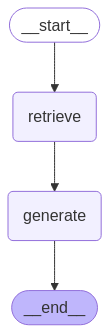

In [55]:
from langgraph.graph import START, END, StateGraph
from IPython.display import display, Image
def retrieve(state:State):
    """Retrieve the relevant documents"""
    retrieve_docs=vector_store.similarity_search(state["question"])
    return {"context":retrieve_docs}

def generate(state:State):
    """Generate the answer using the retrieved documents"""
    docs_content="\n\n".join(doc.page_content for doc in state["context"])
    messages=prompt.invoke({"question":state["question"], "context":docs_content})
    print(messages)
    print("--------------------------------------------------------------------")
    response=llm.invoke( input=messages)
    return {"answer":response.content}

#Creando los nodos
rag_builder=StateGraph(State)
rag_builder.add_node("retrieve", retrieve)
rag_builder.add_node("generate", generate)
# Creando los edges
rag_builder.add_edge(START, "retrieve")
rag_builder.add_edge("retrieve", "generate")
rag_builder.add_edge("generate", END)
rag=rag_builder.compile()
display(Image(rag.get_graph(xray=True).draw_mermaid_png()))



In [56]:
response=rag.invoke({"question":"What is the main idea of the paper?"})
print(response["answer"])

messages=[HumanMessage(content="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: What is the main idea of the paper? \nContext: Provided proper attribution is provided, Google hereby grants permission to\nreproduce the tables and figures in this paper solely for use in journalistic or\nscholarly works.\nAttention Is All You Need\nAshish Vaswani∗\nGoogle Brain\navaswani@google.com\nNoam Shazeer∗\nGoogle Brain\nnoam@google.com\nNiki Parmar∗\nGoogle Research\nnikip@google.com\nJakob Uszkoreit∗\nGoogle Research\nusz@google.com\nLlion Jones∗\nGoogle Research\nllion@google.com\nAidan N. Gomez∗ †\nUniversity of Toronto\naidan@cs.toronto.edu\nŁukasz Kaiser∗\nGoogle Brain\nlukaszkaiser@google.com\nIllia Polosukhin∗ ‡\nillia.polosukhin@gmail.com\nAbstract\nThe dominant sequence transduction models a